In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, first, last, max as _max, min as _min, sum as _sum, avg
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Create Spark session with necessary JARs for S3 access
spark = SparkSession.builder \
    .appName("Read from S3") \
    .config("spark.jars.packages", 
            "org.apache.hadoop:hadoop-aws:3.3.4,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.568") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", 
            "com.amazonaws.auth.profile.ProfileCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.endpoint", "s3.amazonaws.com") \
        .config("spark.driver.memory", "8g") \
        .config("spark.executor.memory", "8g") \
    .getOrCreate()


25/05/07 06:34:12 WARN Utils: Your hostname, ding-zhang-ubuntu-desktop resolves to a loopback address: 127.0.1.1; using 192.168.0.93 instead (on interface wlo1)
25/05/07 06:34:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/ding-zhang/.ivy2/cache
The jars for the packages stored in: /home/ding-zhang/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7195925a-8049-4b85-a7d9-e7510b1fbcd2;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.568 in central
:: resolution report :: resolve 63ms :: artifacts dl 2ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.568 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.4 from central in [default]
	org.wildf

:: loading settings :: url = jar:file:/home/ding-zhang/anaconda3/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


25/05/07 06:34:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/07 06:34:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# Load Parquet data from S3

df = spark.read.parquet("s3a://cryptospark-dataset/archive/")
df.printSchema()
df.show(5)

25/05/07 06:34:14 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


root
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- volume: float (nullable = true)
 |-- quote_asset_volume: float (nullable = true)
 |-- number_of_trades: integer (nullable = true)
 |-- taker_buy_base_asset_volume: float (nullable = true)
 |-- taker_buy_quote_asset_volume: float (nullable = true)
 |-- open_time: timestamp_ntz (nullable = true)



+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+----------------------------+-------------------+
|   open|   high|    low|  close|  volume|quote_asset_volume|number_of_trades|taker_buy_base_asset_volume|taker_buy_quote_asset_volume|          open_time|
+-------+-------+-------+-------+--------+------------------+----------------+---------------------------+----------------------------+-------------------+
|4261.48|4261.48|4261.48|4261.48|1.775183|         7564.9067|               3|                   0.075183|                   320.39084|2017-08-17 04:00:00|
|4261.48|4261.48|4261.48|4261.48|     0.0|               0.0|               0|                        0.0|                         0.0|2017-08-17 04:01:00|
|4280.56|4280.56|4280.56|4280.56|0.261074|          1117.543|               2|                   0.261074|                    1117.543|2017-08-17 04:02:00|
|4261.48|4261.48|4261.48|4261.48|0.012008|         51.171852|   

In [4]:
# Add a new column 'date' for daily grouping
from pyspark.sql.functions import to_date
df = df.withColumn("date", to_date("open_time"))


### Basic Descriptive Statistics

In [ ]:
# Summary statistics for key numeric columns
df.describe(["open", "high", "low", "close", "volume"]).show()

25/05/07 03:11:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+--------------------+--------------------+-------------------+
|summary|                open|                high|                 low|               close|             volume|
+-------+--------------------+--------------------+--------------------+--------------------+-------------------+
|  count|          1507350137|          1507350137|          1507350137|          1507350137|         1507350137|
|   mean|  2668804.5989923603|  2668927.6850018147|  2668663.7415869674|  2668793.9043806735|  8335918.927547635|
| stddev|3.213175357542141...|3.213175357760682E10|3.213175357291572E10|3.213175357523148...|7.031167176224384E8|
|    min|              1.0E-8|              1.0E-8|              1.0E-8|              1.0E-8|                0.0|
|    max|       4.76802774E14|       4.76802774E14|       4.76802774E14|       4.76802774E14|       1.5729488E12|
+-------+--------------------+--------------------+--------------------+----------------

In [5]:
# Time Range 
df.select(min("open_time").alias("start_date"), max("open_time").alias("end_date")).show()

+-------------------+-------------------+
|         start_date|           end_date|
+-------------------+-------------------+
|2017-07-14 04:00:00|2022-11-17 22:22:00|
+-------------------+-------------------+



### Daily Aggregates

In [5]:
# Aggregate to daily OHLCV
daily_df = df.groupBy("date").agg(
    first("open").alias("open"),
    last("close").alias("close"),
    _max("high").alias("high"),
    _min("low").alias("low"),
    avg("close").alias("avg_close"),
    _sum("volume").alias("total_volume")
).orderBy("date")

# Cache the result for faster access in future steps (avoiding recomputation)
daily_df.cache()

DataFrame[date: date, open: float, close: float, high: float, low: float, avg_close: double, total_volume: double]

In [ ]:
# Repartition the data based on 'date' to improve parallelism before the window operation
repartitioned_df = daily_df.repartition(100, "date")  # Adjust the number of partitions as needed

# Define window specification: partition by 'date' (or 'symbol' if you have multiple symbols)
window_spec = Window.partitionBy("date").orderBy("date").rowsBetween(-6, 0)

# Add 7-day moving averages for 'close' and 'volume'
daily_df = repartitioned_df.withColumn("ma_close", avg("close").over(window_spec)) \
                           .withColumn("ma_volume", avg("total_volume").over(window_spec))

# Cache the results again to speed up future accesses
daily_df.cache()



DataFrame[date: date, open: float, close: float, high: float, low: float, avg_close: double, total_volume: double, ma_close: double, ma_volume: double]

In [7]:
# Check row count to ensure safe Pandas conversion
print("Daily count:", daily_df.count())

Daily count: 1953


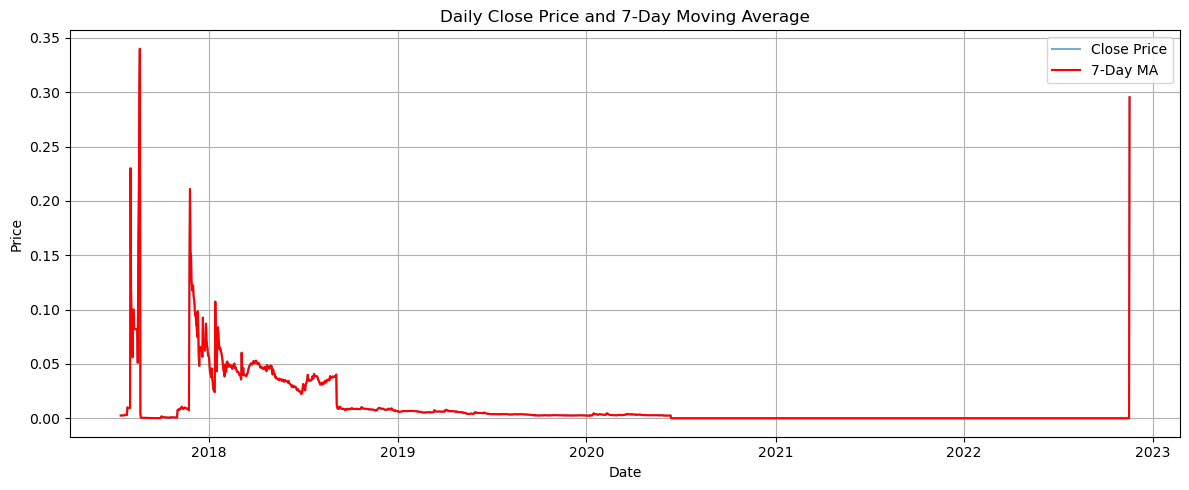

In [ ]:
# To avoid memory issues, only convert the aggregated daily data to Pandas
# Check data size first to avoid running out of memory
daily_pd = daily_df.limit(2000).toPandas()  # Limit to the first 2000 rows for visualization
daily_pd["date"] = pd.to_datetime(daily_pd["date"])
daily_pd = daily_pd.sort_values("date")


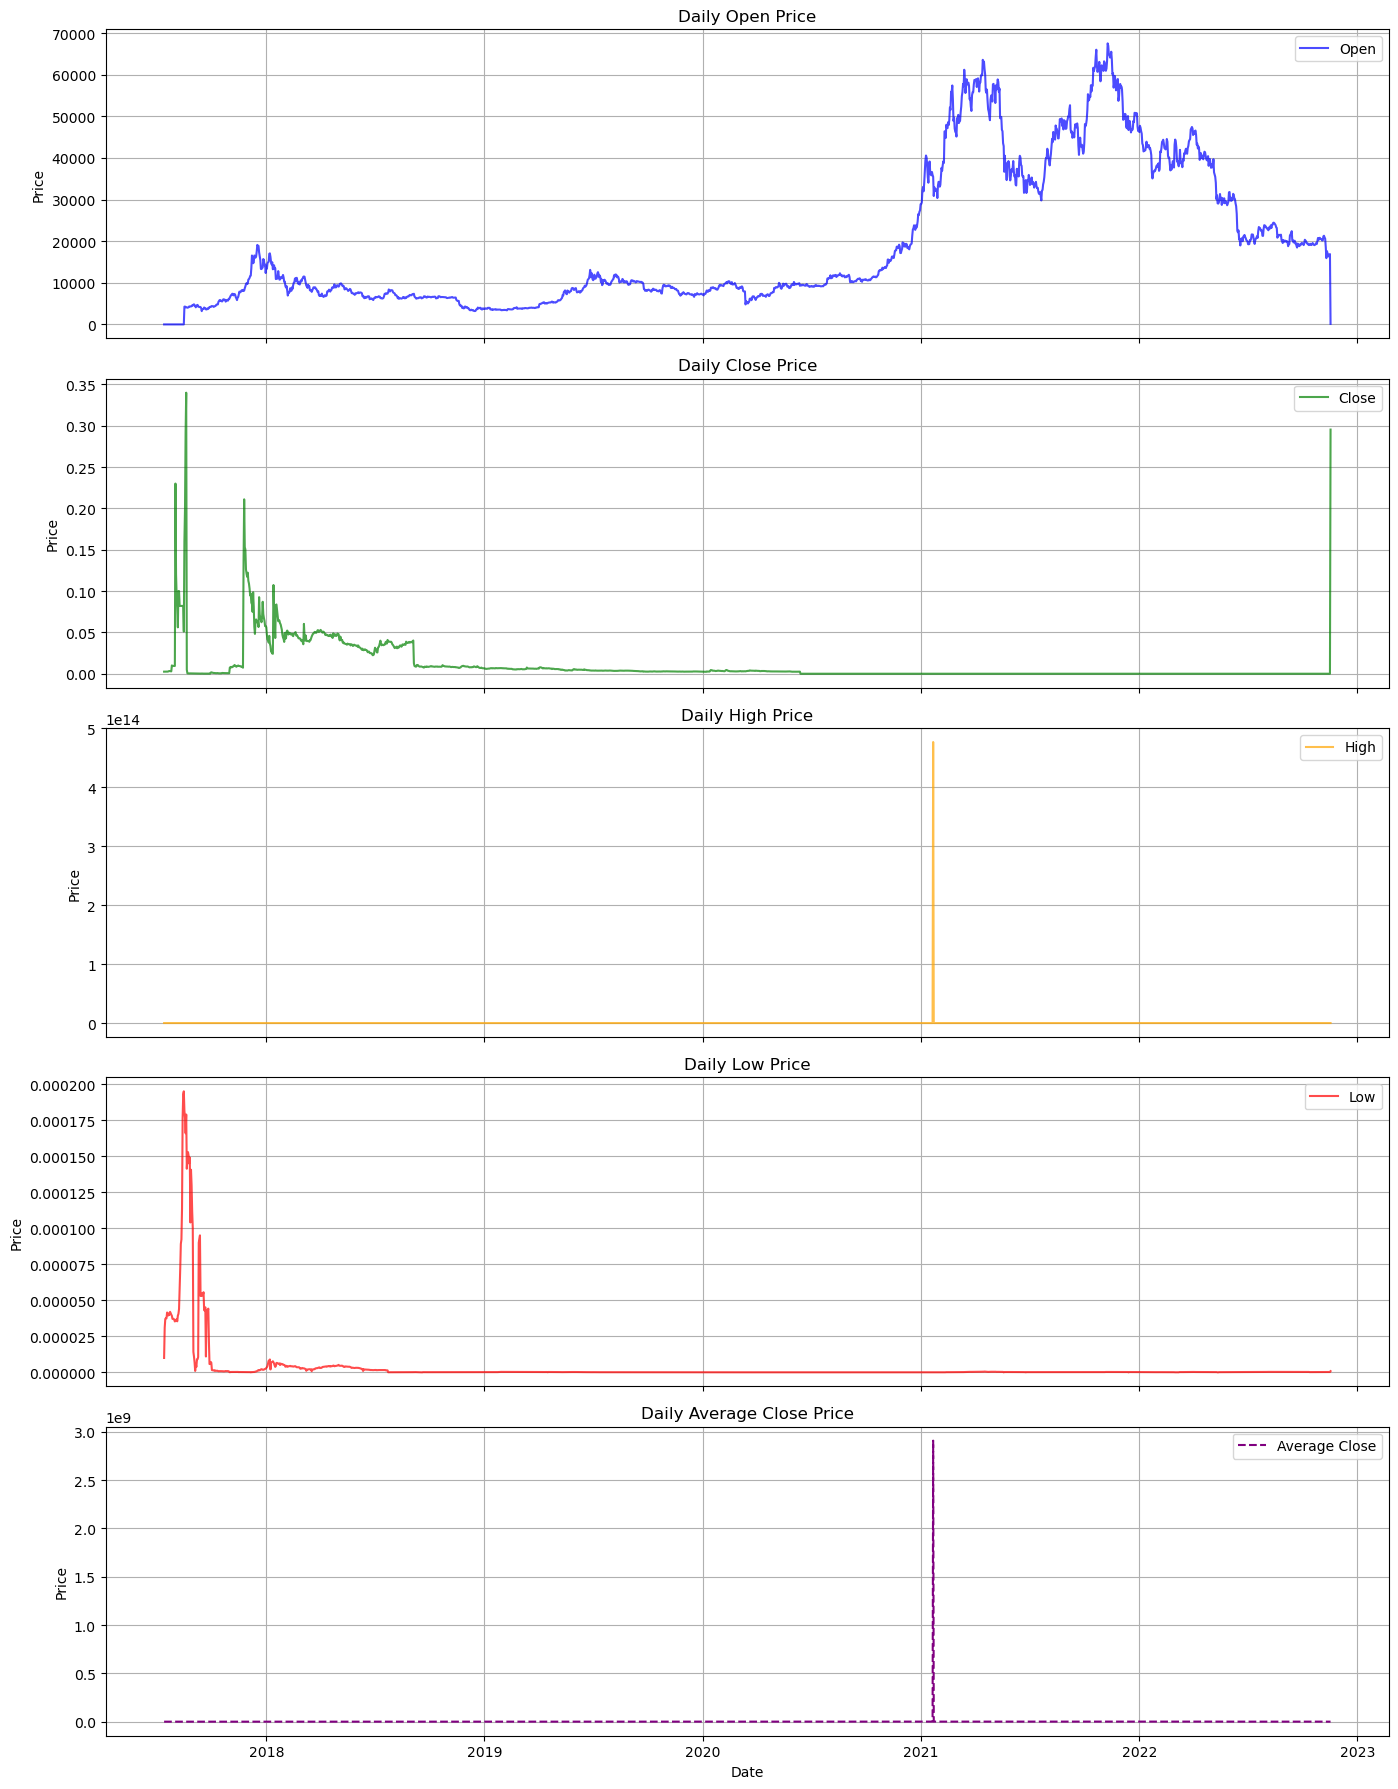

In [18]:
import matplotlib.pyplot as plt

# Set up the figure layout
fig, axes = plt.subplots(5, 1, figsize=(14, 18), sharex=True)

# Plot Open Price
axes[0].plot(daily_pd["date"], daily_pd["open"], label="Open", color="blue", alpha=0.7)
axes[0].set_title("Daily Open Price")
axes[0].set_ylabel("Price")
axes[0].legend()
axes[0].grid(True)

# Plot Close Price
axes[1].plot(daily_pd["date"], daily_pd["close"], label="Close", color="green", alpha=0.7)
axes[1].set_title("Daily Close Price")
axes[1].set_ylabel("Price")
axes[1].legend()
axes[1].grid(True)

# Plot High Price
axes[2].plot(daily_pd["date"], daily_pd["high"], label="High", color="orange", alpha=0.7)
axes[2].set_title("Daily High Price")
axes[2].set_ylabel("Price")
axes[2].legend()
axes[2].grid(True)

# Plot Low Price
axes[3].plot(daily_pd["date"], daily_pd["low"], label="Low", color="red", alpha=0.7)
axes[3].set_title("Daily Low Price")
axes[3].set_ylabel("Price")
axes[3].legend()
axes[3].grid(True)

# Plot Avg Close
axes[4].plot(daily_pd["date"], daily_pd["avg_close"], label="Average Close", color="purple", linestyle="--")
axes[4].set_title("Daily Average Close Price")
axes[4].set_xlabel("Date")
axes[4].set_ylabel("Price")
axes[4].legend()
axes[4].grid(True)

plt.tight_layout()
plt.show()


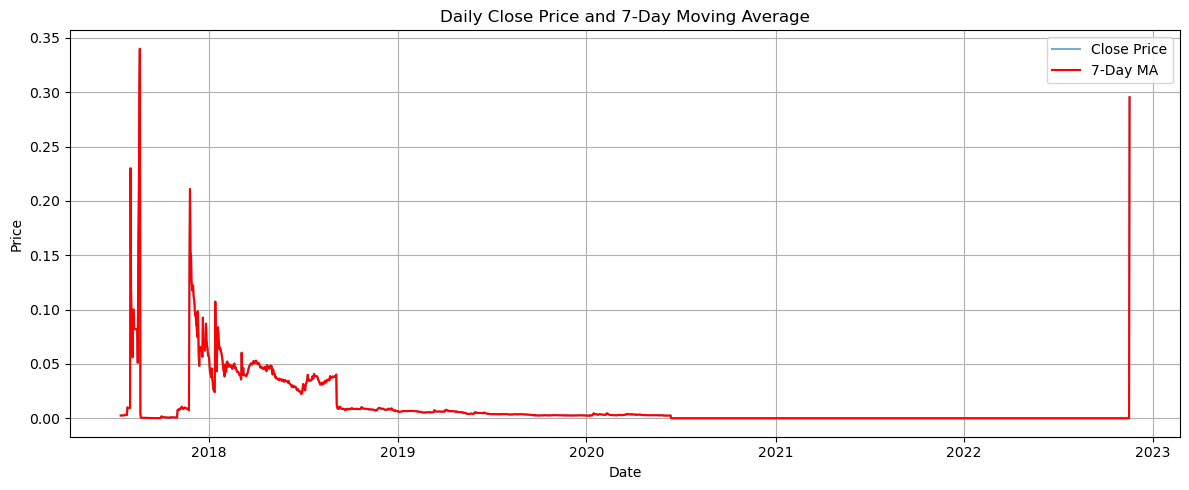

In [19]:
daily_pd = daily_pd.dropna(subset=["close", "ma_close"])

# Plot: Daily Close with 7-day Moving Average
plt.figure(figsize=(12, 5))
plt.plot(daily_pd["date"], daily_pd["close"], label="Close Price", alpha=0.6)
plt.plot(daily_pd["date"], daily_pd["ma_close"], label="7-Day MA", color="red")
plt.title("Daily Close Price and 7-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


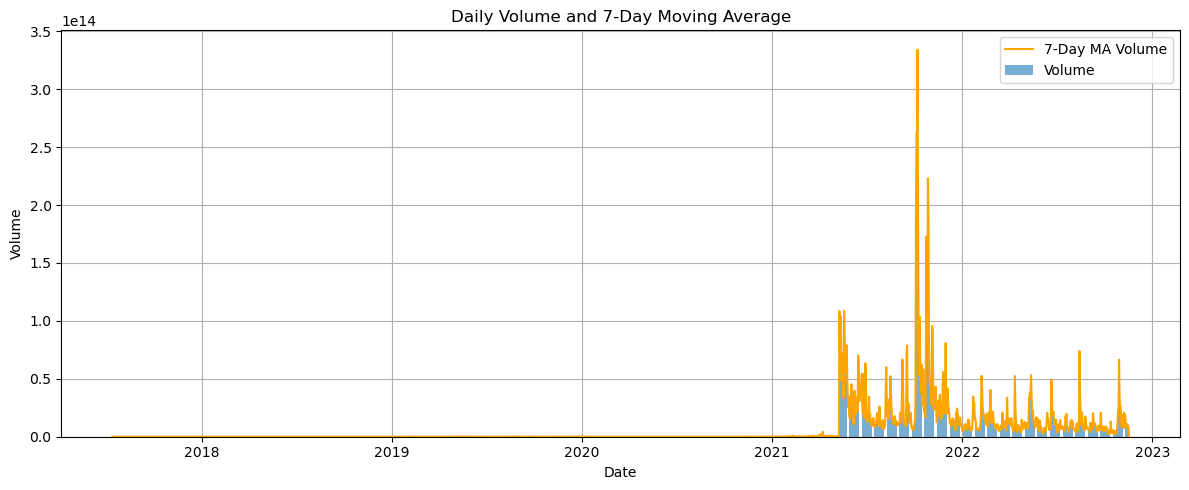

In [20]:
## Plot: Daily Volume with 7-day Moving Average
plt.figure(figsize=(12, 5))
plt.bar(daily_pd["date"], daily_pd["total_volume"], label="Volume", alpha=0.6)
plt.plot(daily_pd["date"], daily_pd["ma_volume"], label="7-Day MA Volume", color="orange")
plt.title("Daily Volume and 7-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
